# P7 : Modélisation, expérimentations et tracking des modèles

In [1]:
# File system management
import os
import pickle
import dill
import gc
import time

from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Scikit-learn
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# Data drift
!pip install evidently
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

#warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)


In [3]:
path = "./P7/" # Chemin pour l'ensemble des données

In [4]:
# Load data
data = pd.read_csv("./P7/train_feature_engineering.csv", index_col=[0])
data_test = pd.read_csv("./P7/test_feature_engineering.csv", index_col=[0])

In [5]:
data_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,...,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVideo_MEAN,PREV_NAME_GOODS_CATEGORY_AutoAccessories_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_

In [6]:
data.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,...,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVideo_MEAN,PREV_NAME_GOODS_CATEGORY_AutoAccessories_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_HouseConstruction_MEAN,PREV_

In [7]:
data.set_index('SK_ID_CURR', inplace = True)
data_test.set_index('SK_ID_CURR', inplace = True)

# Functions

In [8]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [9]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    plt.savefig("roc_curve.png")

    # Return AUC score
    return auc

In [10]:
# Return the best model from hyperopt trials
def trials_best_model(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_idx = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_idx]
    print("Best result :", best_trial_obj['result']['loss'])
    return best_trial_obj['result']['model']

# MLFlow

### Initialisation des tracking MLFlow

In [11]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Create experiment
experiment_name = 'credit_scoring_experiments'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

In [13]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, num_leaves=None, learning_rate=None, min_child_samples=None, min_data_in_leaf=None, colsample_bytree=None,
               subsample=None, reg_alpha=None, reg_lambda=None, auc_score=None, f1_score=None, acc_score=None, train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("num_leaves", num_leaves)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("min_child_samples", min_child_samples)
        mlflow.log_param("min_data_in_leaf", min_data_in_leaf)
        mlflow.log_param("colsample_bytree", colsample_bytree)
        mlflow.log_param("subsample", subsample)
        mlflow.log_param("reg_alpha", reg_alpha)
        mlflow.log_param("reg_lambda", reg_lambda)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)
        mlflow.log_artifact("roc_curve.png")

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

# Préparation des données

In [14]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
training_size = 0.8

# Define seed for random state
seed = 123

## Split data

In [15]:
# Split dataset (filled)
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=training_size, random_state=seed)

In [16]:
# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Balance data

In [17]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0: 226135, 1: 19870})
Testing target statistics: Counter({0: 56547, 1: 4955})
Ratio is 1:11


#### Nous définissons un pipeline qui transforme d'abord l'ensemble de données d'entraînement avec SMOTE, puis ajuste le modèle.

In [18]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
# steps = [('over', over)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
X_res, y_res = pipeline.fit_resample(X_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Training target statistics: Counter({0: 113067, 1: 113067})
Testing target statistics: Counter({0: 56547, 1: 4955})


## Fonction de coût métier

#### Règle : coût FN (ne pas rembourser - prévu comme rembourser) = 10 coût FP (rembourser - prévu comme ne pas rembourser)

In [19]:
# Custom loss function based on business rule
def business_loss_func(y_true, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    cost = (fp + (10 * fn)) / len(y_true)
    return float(cost)

#### Nous créons un score approprié pour les besoins du métier

In [20]:
# Create business score
business_score = make_scorer(business_loss_func, greater_is_better=False)

## Classification

In [21]:
# Function to compute predictions and metrics
def compute_classification_results(model, model_name, X_test, y_test):

    # Predict probability of class 1 (repay failure)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Predict values 
    y_pred = model.predict(X_test)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Draw roc curve
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Compute scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    # Display business loss func
    business_score = business_loss_func(y_test, y_pred)
    print("Business score =", business_score)

    return business_score, auc_score, clf_report

### DummyClassifier

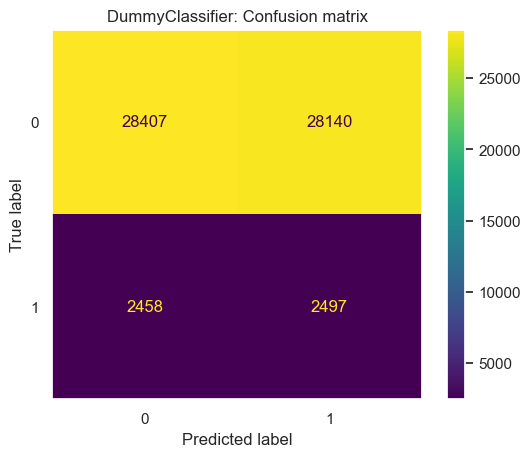

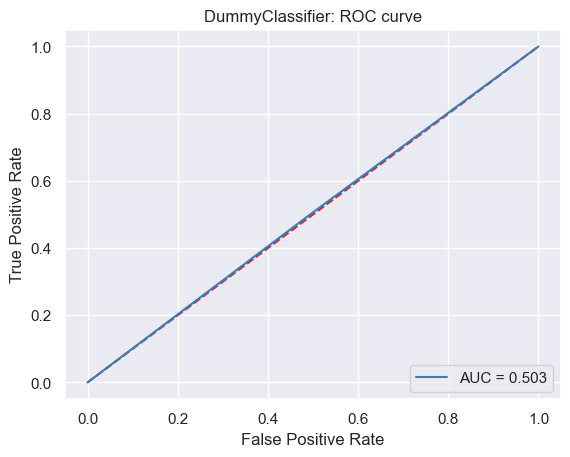

,precision,recall,f1-score,support
0,0.920363,0.502361,0.649957,56547.000000
1,0.081503,0.503935,0.140312,4955.000000
accuracy,0.502488,0.502488,0.502488,0.502488
macro avg,0.500933,0.503148,0.395134,61502.000000
weighted avg,0.852779,0.502488,0.608896,61502.000000


Business score = 0.8572078956781893


Setuptools is replacing distutils.


CPU times: total: 2.14 s
Wall time: 20.7 s


<Figure size 640x480 with 0 Axes>

In [22]:
%%time

# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=seed)
dc_name = 'DummyClassifier'

# Fit model
dc.fit(X_res, y_res)

# Compute results
dc_business_score, dc_auc, dc_report = compute_classification_results(dc, dc_name, X_test, y_test)

# Save logs
log_mlflow(dc, dc_name, auc_score=dc_auc, custom_score=dc_business_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=dc_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])

### LogisticRegression

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


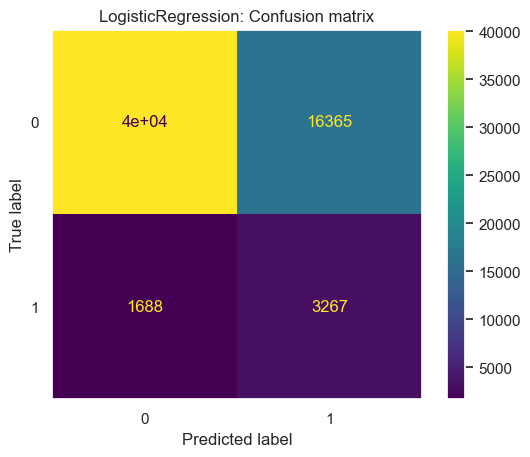

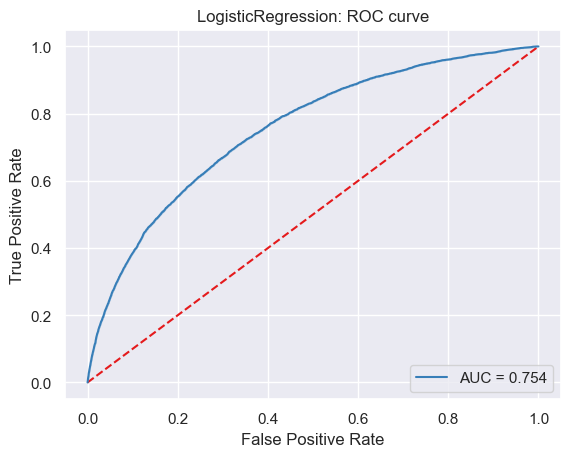

,precision,recall,f1-score,support
0,0.959685,0.710595,0.816566,56547.000000
1,0.166412,0.659334,0.265750,4955.000000
accuracy,0.706465,0.706465,0.706465,0.706465
macro avg,0.563048,0.684964,0.541158,61502.000000
weighted avg,0.895774,0.706465,0.772189,61502.000000


Business score = 0.5405515267796169
CPU times: total: 3min 28s
Wall time: 3min 50s


<Figure size 640x480 with 0 Axes>

In [23]:
%%time

# Create logistic regression model
lr = LogisticRegression(random_state=seed)
lr_name = 'LogisticRegression'

# Train model
lr.fit(X_res, y_res)

# Compute results
lr_business_score, lr_auc, lr_report = compute_classification_results(lr, lr_name, X_test, y_test)

# Save logs
log_mlflow(lr, lr_name, auc_score=lr_auc, custom_score=lr_business_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])

### RandomForest

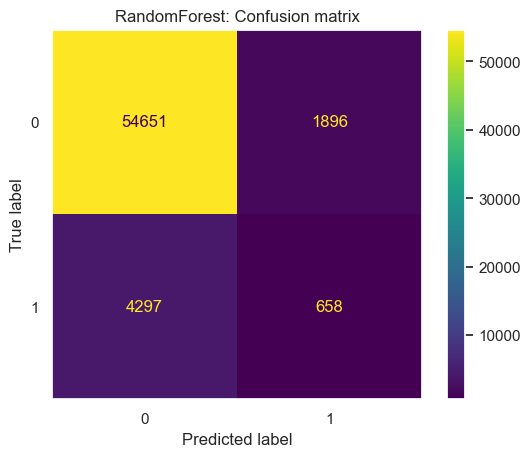

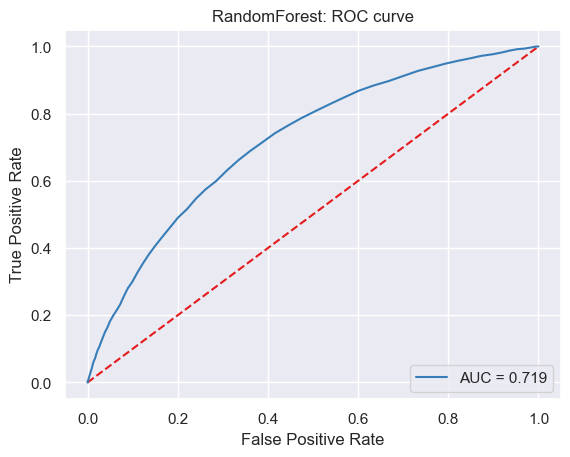

,precision,recall,f1-score,support
0,0.927105,0.966470,0.946379,56547.000000
1,0.257635,0.132795,0.175256,4955.000000
accuracy,0.899304,0.899304,0.899304,0.899304
macro avg,0.592370,0.549633,0.560817,61502.000000
weighted avg,0.873168,0.899304,0.884252,61502.000000


Business score = 0.7295047315534454
CPU times: total: 29min 46s
Wall time: 33min 34s


<Figure size 640x480 with 0 Axes>

In [24]:
%%time

# Create random forest classifier
rf = RandomForestClassifier(random_state=seed)
rf_name = 'RandomForest'

# Train model
rf.fit(X_res, y_res)

# Compute results
rf_business_score, rf_auc, rf_report = compute_classification_results(rf, rf_name, X_test, y_test)

# Save logs
rf_params = rf.get_params()
log_mlflow(rf, rf_name,
           custom_score=rf_business_score,
           auc_score=rf_auc,
           f1_score=rf_report.loc['weighted avg', 'f1-score'], 
           acc_score=rf_report.loc['accuracy', 'precision'],
           n_estimator=rf_params['n_estimators'],
           max_depth=rf_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

### LightGBM

[LightGBM] [Info] Number of positive: 113067, number of negative: 113067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.388230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123583
[LightGBM] [Info] Number of data points in the train set: 226134, number of used features: 543
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


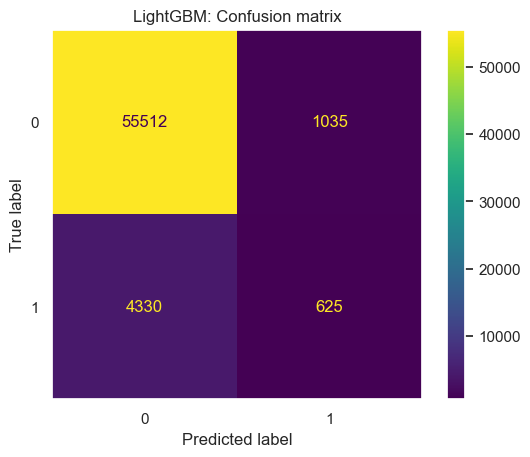

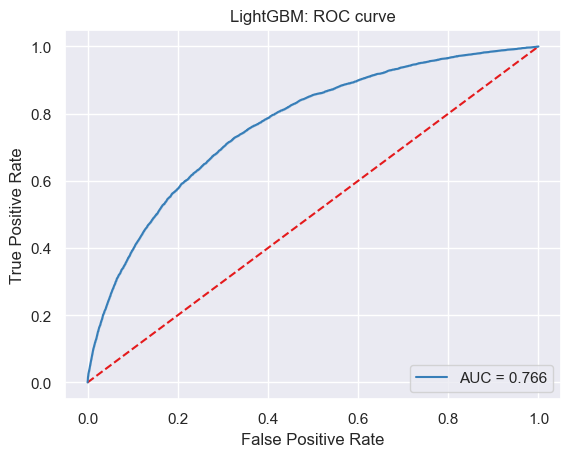

,precision,recall,f1-score,support
0,0.927643,0.981697,0.953905,56547.000000
1,0.376506,0.126135,0.188964,4955.000000
accuracy,0.912767,0.912767,0.912767,0.912767
macro avg,0.652074,0.553916,0.571435,61502.000000
weighted avg,0.883240,0.912767,0.892276,61502.000000


Business score = 0.7208708659880979
CPU times: total: 6min 33s
Wall time: 4min 16s


<Figure size 640x480 with 0 Axes>

In [25]:
%%time

# Create LightGBM classifier
lgbm = ltb.LGBMClassifier(random_state=seed)
lgbm_name = 'LightGBM'

# Train model
lgbm.fit(X_res, y_res)

# Compute results
lgbm_business_score, lgbm_auc, lgbm_report = compute_classification_results(lgbm, lgbm_name, X_test, y_test)

# Save logs
lgbm_params = lgbm.get_params()
log_mlflow(lgbm, lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

### Comparons les différents modèles

In [26]:
# Create results dataframe
res_df = pd.DataFrame({
    'Model':['Dummy', 'LogisticRegression', 'RandomForest', 'LightGBM'],
    'Business score': [dc_business_score, lr_business_score, rf_business_score, lgbm_business_score],
    'Accuracy': [dc_report.loc['accuracy', 'precision'],
                 lr_report.loc['accuracy', 'precision'],
                 rf_report.loc['accuracy', 'precision'],
                 lgbm_report.loc['accuracy', 'precision']],
    'Precision': [dc_report.loc['macro avg', 'precision'],
                 lr_report.loc['macro avg', 'precision'],
                 rf_report.loc['macro avg', 'precision'],
                 lgbm_report.loc['macro avg', 'precision']],
    'Recall': [dc_report.loc['macro avg', 'recall'],
               lr_report.loc['macro avg', 'recall'],
               rf_report.loc['macro avg', 'recall'],
               lgbm_report.loc['macro avg', 'recall']],
    'F-1 score': [dc_report.loc['macro avg', 'f1-score'],
                  lr_report.loc['macro avg', 'f1-score'],
                  rf_report.loc['macro avg', 'f1-score'],
                 lgbm_report.loc['macro avg', 'f1-score']],
    'AUC score': [dc_auc, lr_auc, rf_auc, lgbm_auc],
})

display(res_df)

,Model,Business score,Accuracy,Precision,Recall,F-1 score,AUC score
0,Dummy,0.857208,0.502488,0.500933,0.503148,0.395134,0.503148
1,LogisticRegression,0.540552,0.706465,0.563048,0.684964,0.541158,0.753695
2,RandomForest,0.729505,0.899304,0.592370,0.549633,0.560817,0.718714
3,LightGBM,0.720871,0.912767,0.652074,0.553916,0.571435,0.766116


#### Au vue de ce tableau de comparaison, le modèle qui minimise le score métier est celui de la Regression logistique. Cependant le modèle LightGBM en plus d'un score métier 
#### un peu plus élevé, donne également des un AUC score le plus élevé ainsi qu'une meilleure précision. Des 4 modèles évalués c'est celui qui donne la combinaison de scores la plus plus intéressante. Nous retenons donc ce modèle comme celui dont nous allons optimiser les hyperparamètres.

### Optimisation des hyperparamètre du modèle retenu LGBMClassifier

##### LGBMClassifier optimisé

{'colsample_bytree': 1.0, 'learning_rate': 0.6000000000000001, 'max_depth': 10, 'min_child_samples': 100, 'min_data_in_leaf': 250, 'n_estimators': 200, 'num_leaves': 12, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.8, 'subsample': 0.8690328766542432}
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Warning] min_data_in_leaf is set=250, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=250
[LightGBM] [Info] Number of positive: 90454, number of negative: 90453                                                 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.073508 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122644                                                                                    
[LightGBM] [Info] Number of data points in the train set: 180907, number of 

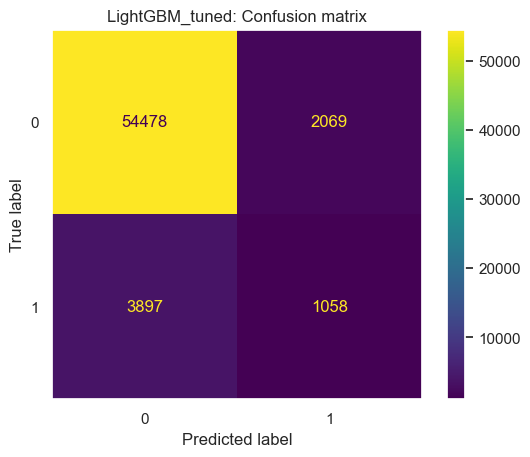

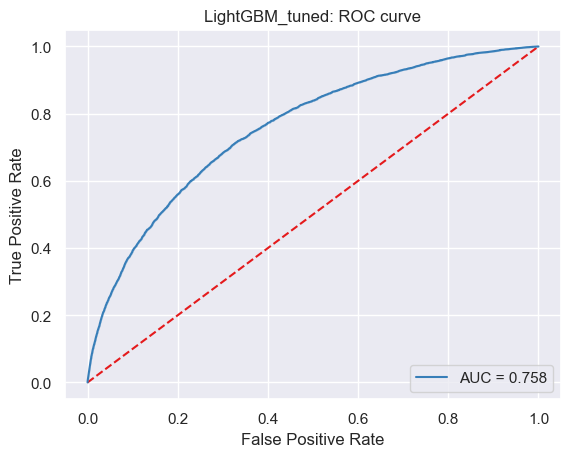

,precision,recall,f1-score,support
0,0.933242,0.963411,0.948087,56547.000000
1,0.338343,0.213522,0.261816,4955.000000
accuracy,0.902995,0.902995,0.902995,0.902995
macro avg,0.635793,0.588466,0.604951,61502.000000
weighted avg,0.885313,0.902995,0.892796,61502.000000


Business score = 0.667279112874378
CPU times: total: 2h 58min 58s
Wall time: 34min 22s


<Figure size 640x480 with 0 Axes>

In [27]:
%%time

# Create LGBM classifier for tuning
lgbmt = ltb.LGBMClassifier(random_state=seed)
lgbmt_name = 'LightGBM_tuned'

# Possible values of hyperparameters
lgbmt_space = {'max_depth':  scope.int(hp.quniform("max_depth", 3, 11, 1)),
              'subsample':  hp.uniform('subsample', 0.5, 1.),
              'colsample_bytree': hp.quniform('colsample_bytree', 0.3, 1, 0.1),
              'learning_rate': hp.quniform('learning_rate', 0.1, 1, 0.1),
              'min_child_samples' : scope.int(hp.quniform('min_child_weight', 0, 200, 50)),
              'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50)),
              'num_leaves': scope.int(hp.quniform("num_leaves", 5, 13, 2)),
              'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 100, 300, 50)),
              'reg_alpha': hp.quniform('reg_alpha', 0.1, 1, 0.1),
              'reg_lambda': hp.quniform('reg_lambda', 0, 1, 0.2)}

# define objective function
def lgbmt_tuning(params):
    print(params)
    lgbmt.set_params(**params)
    score = cross_val_score(lgbmt, X_res, y_res, scoring=business_score).mean()
    return {"loss": -score, "status": STATUS_OK, "model":lgbmt}

# Initialize trials object
lgbmt_trials = Trials()

# Find best model
lgbmt_best = fmin(fn=lgbmt_tuning, space=lgbmt_space, algo=tpe.suggest, max_evals=10, trials=lgbmt_trials)
lgbmt_best_model = trials_best_model(lgbmt_trials)
print(lgbmt_best_model)

# Train model
lgbmt_best_model.fit(X_res, y_res)

# Compute results
lgbmt_business_score, lgbmt_auc, lgbmt_report = compute_classification_results(lgbmt_best_model, lgbmt_name, X_test, y_test)

# Save logs
lgbmt_params = lgbmt.get_params()
log_mlflow(lgbmt_best_model, lgbmt_name,
           custom_score=lgbmt_business_score,
           auc_score=lgbmt_auc,
           f1_score=lgbmt_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbmt_report.loc['accuracy', 'precision'],
           n_estimator=lgbmt_params['n_estimators'],
           max_depth=lgbmt_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

Le modèle LGBMClassifier optimisé améliore bien le score métier tout en conservant un bon AUC score.

In [28]:
lgbm_score_imp = (lgbm_business_score - lgbmt_business_score) / lgbm_business_score
print("The LGBMClassifier tuned model improved the business score by {:.1%}".format(lgbm_score_imp))

The LGBMClassifier tuned model improved the business score by 7.4%


### Custom threshold

In [29]:
# Get proba predictions from lgbmt model to be class 1 : repay failure
lgbmt_proba = lgbmt_best_model.predict_proba(X_test)[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=200 will be ignored. Current value: min_data_in_leaf=150


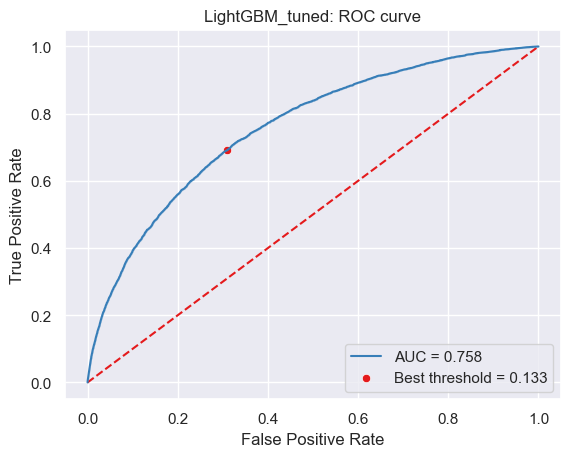

<Figure size 640x480 with 0 Axes>

In [30]:
# Draw roc curve
auc_score = compute_roc_curve(y_test, lgbmt_proba, model_name='LightGBM_tuned', disp_best_th=True)

In [31]:
lgbmt_best_model.get_params

<bound method LGBMModel.get_params of LGBMClassifier(colsample_bytree=0.7000000000000001,
               learning_rate=0.6000000000000001, max_depth=9,
               min_child_samples=200, min_data_in_leaf=150, n_estimators=450,
               num_leaves=6, random_state=123, reg_alpha=0.4, reg_lambda=0.8,
               subsample=0.7120936420086237)>

The best prediction threshold is given by the point where the true positive rate and false positive rate are the lower.
Here it gives us 0.123.

Let's try different value of the prediction threshold :

0.5 - Default
0.3 - Optimized
0.13 - Approximately the thresold given by the ROC curve
0.1 - Lower value than the thresold given by the ROC curve

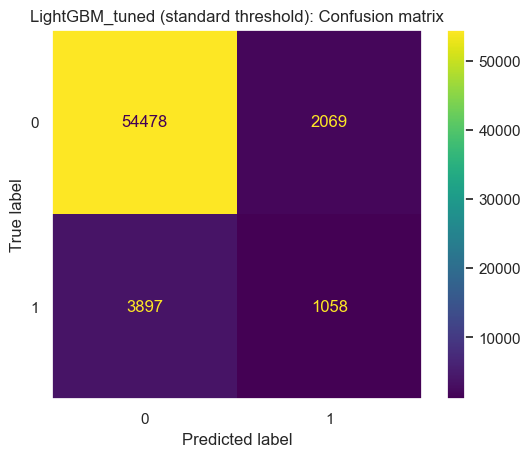

Business score = 0.667279112874378


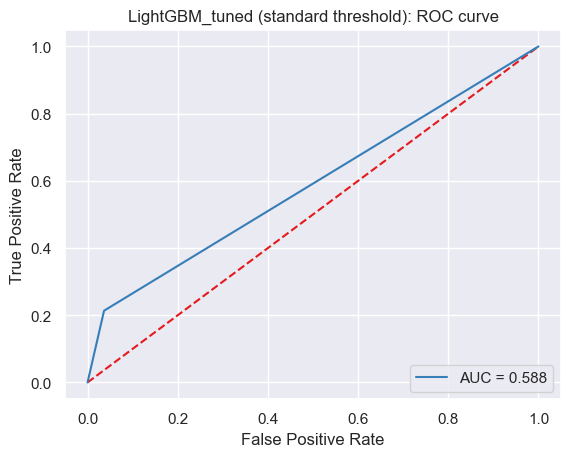

,precision,recall,f1-score,support
0,0.933242,0.963411,0.948087,56547.000000
1,0.338343,0.213522,0.261816,4955.000000
accuracy,0.902995,0.902995,0.902995,0.902995
macro avg,0.635793,0.588466,0.604951,61502.000000
weighted avg,0.885313,0.902995,0.892796,61502.000000


<Figure size 640x480 with 0 Axes>

In [32]:
# Compute confusion matrix with standard threshold (0.5)
lgbmt_pred_std = lgbmt_proba >= 0.5
display_confusion_matrix(y_test, lgbmt_pred_std, model_name='LightGBM_tuned (standard threshold)')
business_score = business_loss_func(y_test, lgbmt_pred_std)
print("Business score =", business_score)
auc_score = compute_roc_curve(y_test, lgbmt_pred_std, model_name='LightGBM_tuned (standard threshold)')
clf_report = pd.DataFrame(classification_report(y_test, lgbmt_pred_std, output_dict=True)).transpose()
display(clf_report)

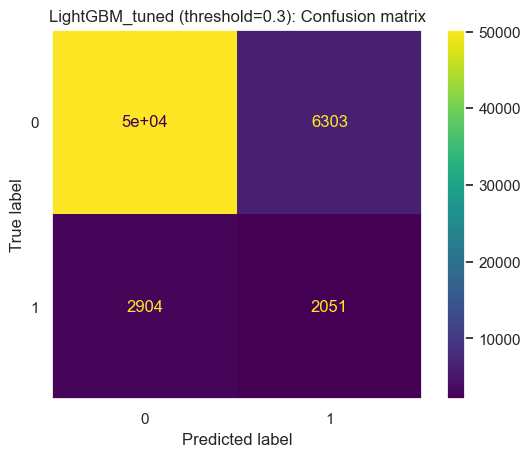

Business score = 0.5746642385613476


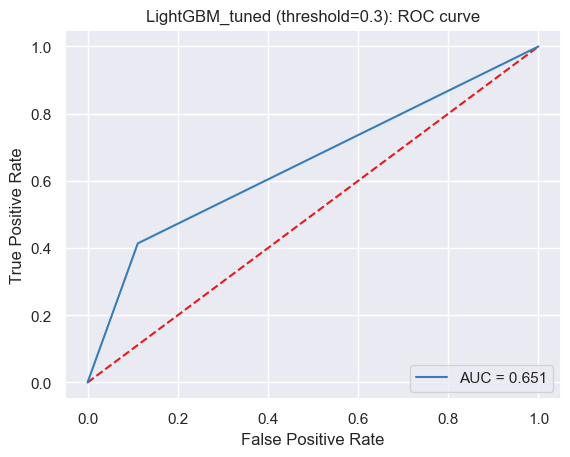

,precision,recall,f1-score,support
0,0.945360,0.888535,0.916067,56547.000000
1,0.245511,0.413925,0.308212,4955.000000
accuracy,0.850298,0.850298,0.850298,0.850298
macro avg,0.595436,0.651230,0.612140,61502.000000
weighted avg,0.888976,0.850298,0.867095,61502.000000


<Figure size 640x480 with 0 Axes>

In [33]:
# Compute confusion matrix with standard threshold (0.3)
lgbmt_pred_cstm = lgbmt_proba >= 0.3
display_confusion_matrix(y_test, lgbmt_pred_cstm, model_name='LightGBM_tuned (threshold=0.3)')
business_score = business_loss_func(y_test, lgbmt_pred_cstm)
print("Business score =", business_score)
auc_score = compute_roc_curve(y_test, lgbmt_pred_cstm, model_name='LightGBM_tuned (threshold=0.3)')
clf_report = pd.DataFrame(classification_report(y_test, lgbmt_pred_cstm, output_dict=True)).transpose()
display(clf_report)

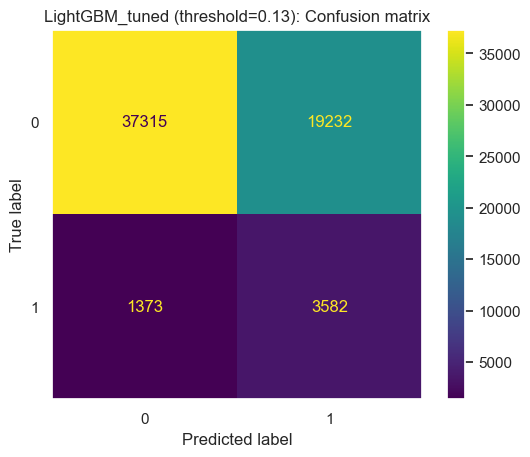

Business score = 0.5359500504048649


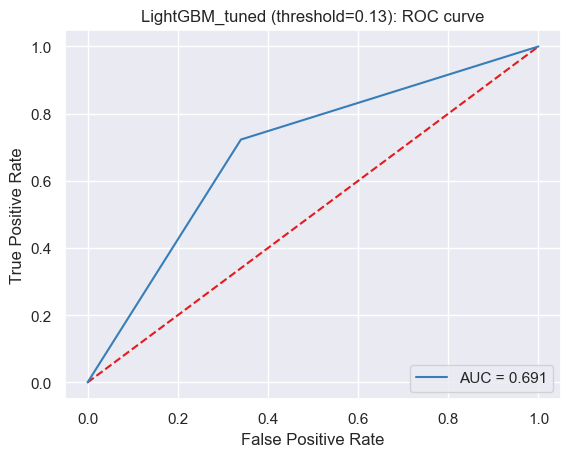

,precision,recall,f1-score,support
0,0.964511,0.659894,0.783640,56547.00000
1,0.157009,0.722906,0.257986,4955.00000
accuracy,0.664970,0.664970,0.664970,0.66497
macro avg,0.560760,0.691400,0.520813,61502.00000
weighted avg,0.899453,0.664970,0.741290,61502.00000


<Figure size 640x480 with 0 Axes>

In [38]:
# Compute confusion matrix with standard threshold (0.13)
lgbmt_pred_optim = lgbmt_proba >= 0.12
display_confusion_matrix(y_test, lgbmt_pred_optim, model_name='LightGBM_tuned (threshold=0.13)')
business_score = business_loss_func(y_test, lgbmt_pred_optim)
print("Business score =", business_score)
auc_score = compute_roc_curve(y_test, lgbmt_pred_optim, model_name='LightGBM_tuned (threshold=0.13)')
clf_report = pd.DataFrame(classification_report(y_test, lgbmt_pred_optim, output_dict=True)).transpose()
display(clf_report)

## Feature importances et interprétabilité du modèle retenu et optimisé

In [35]:
# Importance des Caractéristiques avec SHAP

explainer = shap.Explainer(lgbmt_best_model, data_test, check_additivity=False)
shap_values = explainer(data_test, check_additivity=False)

100%|===================| 48690/48744 [09:11<00:00]        

### Interpretabilité globale

### Impact de chaque caractéristique sur la prédiction du modèle

Le diagramme de valeurs SHAP ci-dessous indique également comment chaque caractéristique impacte la variable dépendante

Les valeurs de Shap sont représentées pour chaque variable dans leur ordre d’importance, chaque point représente une valeur de Shap (pour un client), les points rouges représentent des valeurs élevées de la variable et les points bleus des valeurs basses de la variable.

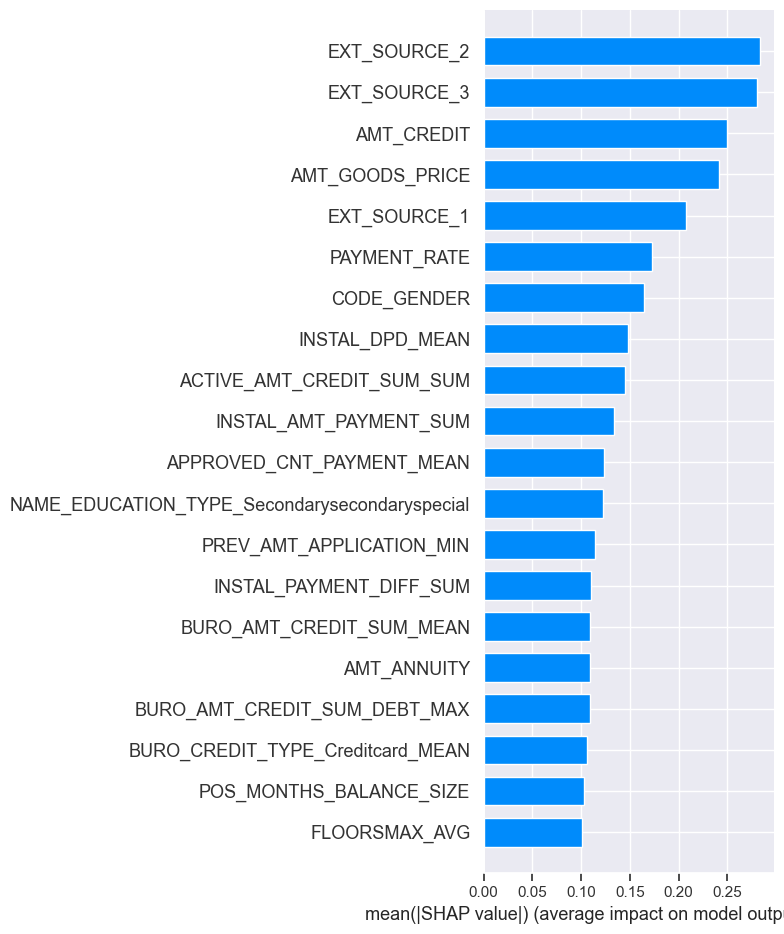

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


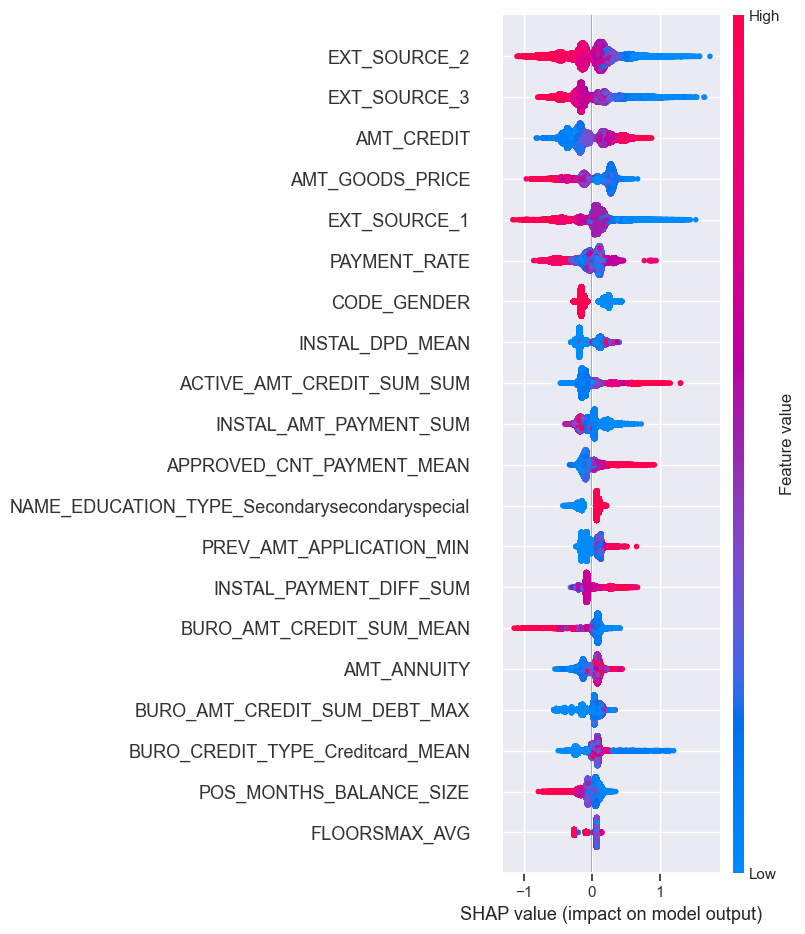

In [36]:
# Graphiques SHAP globaux
shap.summary_plot(shap_values, data_test, plot_type="bar")
shap.summary_plot(shap_values, data_test)

### Interprétabilité locale : Impact de chaque caractéristique sur la prédiction individuelle d'un client

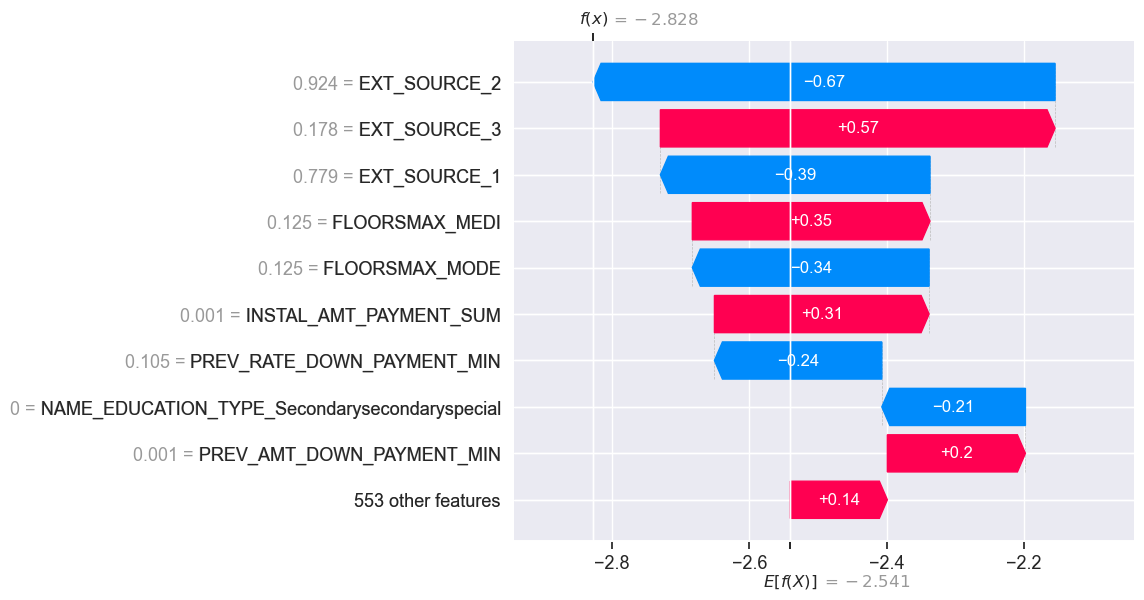

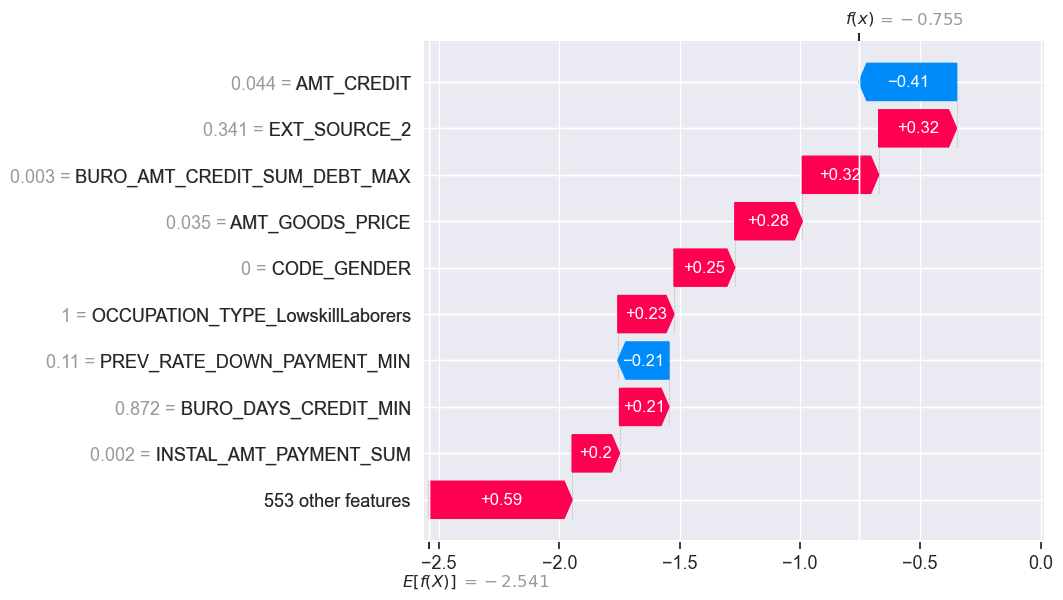

In [37]:
# Graphiques SHAP locaux pour quelques exemples
for i in range(2):
    shap.plots.waterfall(shap_values[i])

In [44]:
lgbmt_best_model.get_params

<bound method LGBMModel.get_params of LGBMClassifier(colsample_bytree=0.7000000000000001,
               learning_rate=0.6000000000000001, max_depth=9,
               min_child_samples=200, min_data_in_leaf=150, n_estimators=450,
               num_leaves=6, random_state=123, reg_alpha=0.4, reg_lambda=0.8,
               subsample=0.7120936420086237)>

In [48]:
with open('lgbmt_best_model.pkl', 'wb') as file:
    pickle.dump(lgbmt_best_model, file)

In [68]:
data_test_sampled = pd.read_csv("./P7/test_feature_engineering_sampled.csv", index_col=[0])

In [70]:
data_test_sampled.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,...,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVideo_MEAN,PREV_NAME_GOODS_CATEGORY_AutoAccessories_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN,PREV_NAME_GOODS_CATEGORY_

In [73]:
data_test_sampled.set_index('SK_ID_CURR', inplace = True)

In [74]:
data_test_sampled

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,...,PREV_NAME_GOODS_CATEGORY_Animals_MEAN,PREV_NAME_GOODS_CATEGORY_AudioVideo_MEAN,PREV_NAME_GOODS_CATEGORY_AutoAccessories_MEAN,PREV_NAME_GOODS_CATEGORY_ClothingandAccessories_MEAN,PREV_NAME_GOODS_CATEGORY_Computers_MEAN,PREV_NAME_GOODS_CATEGORY_ConstructionMaterials_MEAN,PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN,PREV_NAME_GOODS_CATEGORY_DirectSales_MEAN,PREV_NAME_GOODS_CATEGORY_Education_MEAN,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_GOODS_CATEGORY_Furniture_MEAN,PREV_NAME_GOODS_CATEGORY_Gardening_MEAN,PREV_NAME_GOODS_CATEGORY_Homewares_MEAN

In [1]:
pip list

Package                                  Version
---------------------------------------- --------------
absl-py                                  2.1.0
aiofiles                                 22.1.0
aiosqlite                                0.18.0
alembic                                  1.13.2
aniso8601                                9.0.1
annotated-types                          0.5.0
anyascii                                 0.3.2
anyio                                    3.5.0
appdirs                                  1.4.4
argon2-cffi                              21.3.0
argon2-cffi-bindings                     21.2.0
arrow                                    1.3.0
asttokens                                2.0.5
astunparse                               1.6.3
attrs                                    23.1.0
Babel                                    2.11.0
backcall                                 0.2.0
backoff                                  2.2.1
beautifulsoup4                           4